In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.stats as scs

In [71]:
class Mixture():
    def __init__(self, components, weights=None):
        n = len(components)
        if weights is None:
            weights = np.ones(n) / n
        if len(weights) != n:
            raise ValueError("must have same number of weights as components")
        self.components = components
        self.weights = np.array(weights)
        
    def pdf(self, x):
        return sum(w*c.pdf(x) for w,c in zip(self.weights, self.components))
    
    def cdf(self, x):
        return sum(w*c.cdf(x) for w,c in zip(self.weights, self.components))
    
    def mean(self):
        return sum(w*c.mean() for w,c in zip(self.weights, self.components))
    
    def component_means(self):
        return np.array([c.mean() for c in self.components])
    
    def component_vars(self):
        return np.array([c.var() for c in self.components])
    
    def var(self):
        mean_of_vars = self.weights.dot(self.component_vars())
        var_of_means = self.weights.dot((self.component_means() - self.mean())**2)
        return mean_of_vars + var_of_means
    
    def rvs(self, size=1):
        rvs = [c.rvs() for c in np.random.choice(self.components, p=self.weights, size=size).flatten()]
        return rvs[0] if size == 1 else np.array(rvs).reshape(size)

## Define function to sample flour consumption in the population

In [4]:
def sample_flour_consumption(n):
    """Distribution for daily flour consumption (from Ethiopia)"""
    # Define quantiles in g of flour per day
    q0 = 0
    q1 = 77.5
    q2 = 100
    q3 = 200
    q4 = 350.5

    daily_flour_consumption = np.empty(n) # to store the returned sample
    u = np.random.uniform(0,1,size=n) # n random numbers, one for each returned value

    # Define the distribution to be uniform between each quantile
    for i in range(n):
        if u[i] <= 0.25:
            daily_flour_consumption[i] = np.random.uniform(q0,q1)
        elif u[i] <= 0.5:
            daily_flour_consumption[i] = np.random.uniform(q1,q2)
        elif u[i] <= 0.75:
            daily_flour_consumption[i] = np.random.uniform(q2,q3)
        else:
            daily_flour_consumption[i] = np.random.uniform(q3,q4)
        
    return daily_flour_consumption

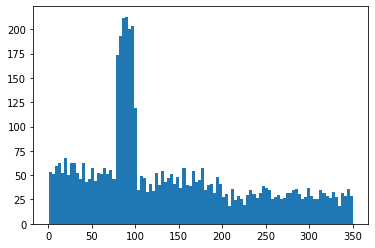

In [15]:
flour_consumption = sample_flour_consumption(5000)
plt.hist(flour_consumption, bins=100)
plt.show()

In [16]:
flour_consumption.mean()

139.67352686269342

In [17]:
flour_consumption.std()

93.15095398257353

## Define other input data for birthweight shift - dose response and iron consumption

### Dose response for iron on birthweight

15.1 grams (95% CI: 6.0, 24.2) per 10 mg of daily iron consumptionn (use normal distribution)

In [19]:
# Define normal distribution for dose-response on birthweight

# mean and 0.975-quantile of normal distribution for mean difference (MD)
mean = 15.1 # g per 10 mg daily iron
q_975 = 24.2 # 97.5th percentile

# 0.975-quantile of standard normal distribution (=1.96, approximately)
q_975_stdnorm = scs.norm().ppf(0.975)

std = (q_975 - mean) / q_975_stdnorm # std dev of normal distribution

# Frozen normal distribution for MD, representing uncertainty in our effect size
dose_response_distribution = scs.norm(mean, std)

# # random sample from effect size distribution
# bw_md_per_10_mg_iron = dose_response_distribution.rvs()

In [21]:
dose_response = dose_response_distribution.rvs()
dose_response

11.439474543479001

### Iron concentration in flour for each country

Ethiopia: 30 mg iron as NaFeEDTA / kg flour;
    use point value

India: 14 to 21.25 mg iron as NaFeEDTA / kg flour;
    sample from uniform distribution with range: 14 - 21.25 (mean 17.625)

Nigeria: 40 mg iron as NaFeEDTA / kg flour;
    use point value
  

In [23]:
# Define India's flour distribution
india_min = 14 # mg iron as NaFeEDTA per kg Flour
india_max = 21.25
scale = india_max-india_min
india_iron_conc_distribution = scs.uniform(loc=india_min, scale=scale)
india_iron_conc_distribution.mean()

17.625

In [25]:
india_iron_concentration = india_iron_conc_distribution.rvs()
india_iron_concentration

15.60528620463802

In [35]:
# Define degenerate distributions to sample iron concentration in Ethiopia and Nigreia
# (We define distributions for consistency with India in the "multiple draws" function below)
ethiopia_iron_conc_distribution = scs.bernoulli(p=0,loc=30) # 30 mg iron as NaFeEDTA per kg flour
nigeria_iron_conc_distribution = scs.bernoulli(p=0,loc=40) # 40 mg iron as NaFeEDTA per kg flour

In [36]:
print(ethiopia_iron_conc_distribution.rvs(5))
print(nigeria_iron_conc_distribution.rvs(5))

[30 30 30 30 30]
[40 40 40 40 40]


## Define function to compute birthweight shift, and plot the distribution of shifts

In [18]:
def birthweight_shift(dose_response, iron_concentration, daily_flour):
    """
    Computes the increase in birthweight (in grams) given the following:
    
    dose_response: g of birthweight increase per 10 mg daily iron
    iron_concentration: mg iron as NaFeEDTA per kg flour
    daily flour: g of iron eaten per day by pregnant mother
    """
    return (dose_response/10)*(iron_concentration)*(daily_flour/1_000)

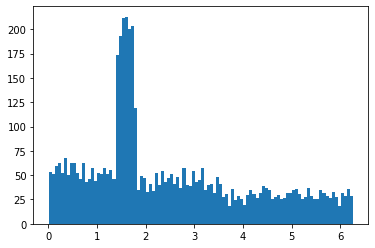

In [27]:
bw_shifts = birthweight_shift(dose_response, india_iron_concentration, flour_consumption)
plt.hist(bw_shifts, bins=100)
plt.show()

In [28]:
print(bw_shifts.mean(), bw_shifts.std())

2.493399763130747 1.6628961250751446


## Get an idea of the range of possible mean birthweight shifts in India

In [29]:
for i in range(20):
    dose_response = dose_response_distribution.rvs()
    india_iron_concentration = india_iron_conc_distribution.rvs()
    bw_shifts = birthweight_shift(dose_response, india_iron_concentration, flour_consumption)
    print(bw_shifts.mean(), bw_shifts.std())

4.732073748339573 3.155910743250946
2.767686254879969 1.8458230471975479
4.918623304678858 3.2803242203668574
4.4507670752688595 2.968301927559188
5.9569988543598695 3.972836790340492
4.366062958578201 2.911811127525602
5.233196665640815 3.4901192282635
2.2243205924380125 1.4834420652409697
6.011699033402339 4.00931738888536
3.4183702800430997 2.279776703603398
4.923892205978295 3.283838151700209
3.188792589343235 2.1266669384090844
3.5044342124253336 2.3371743908027613
2.9116231432699045 1.9418173187532906
4.707735440243864 3.139679058776724
6.090091495489179 4.061598825407044
2.692815444455322 1.7958902677141426
5.380999030174214 3.588691459998587
4.486060029318343 2.991839475528492
5.032314329000138 3.356146945063959


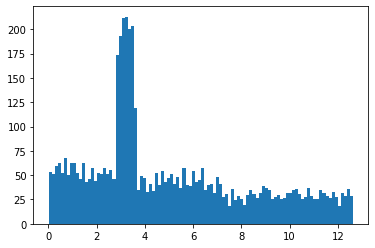

In [37]:
# Plot the final distribution of birthweight shifts (one draw) for India
plt.hist(bw_shifts, bins=100)
plt.show()

## Plot the overall distribution including parameter uncertainty (multiple draws)

In [38]:
def birthweight_shift_over_draws(dose_response_distribution,
                                 iron_conc_distribution,
                                 population_size,
                                 num_draws,
                                 ):
    bw_shifts = np.empty((num_draws,population_size))
    dose_response = dose_response_distribution.rvs(num_draws)
    iron_concentration = iron_conc_distribution.rvs(num_draws)
    for i in range(num_draws):
        daily_flour = sample_flour_consumption(population_size)
        bw_shifts[i] = birthweight_shift(dose_response[i], iron_concentration[i], daily_flour)
    
    return bw_shifts

In [53]:
1_000*25

25000

In [51]:
bw_shifts = birthweight_shift_over_draws(
    dose_response_distribution,
    india_iron_conc_distribution,
    population_size=1_000,
    num_draws=25,
)
bw_shifts.flatten().mean()

3.6021941408854397

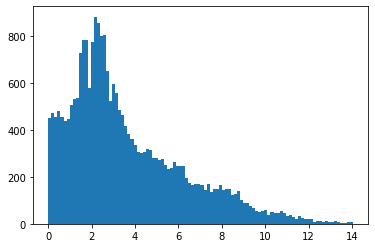

In [52]:
plt.hist(bw_shifts.flatten(),bins=100)
plt.show()

In [54]:
bw_shifts = birthweight_shift_over_draws(
    dose_response_distribution,
    ethiopia_iron_conc_distribution,
    population_size=1_000,
    num_draws=25,
)
bw_shifts.flatten().mean()

6.647039654325064

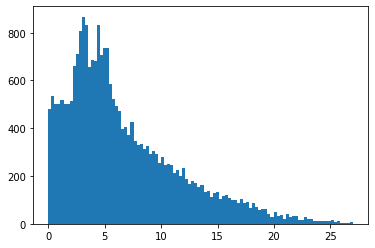

In [55]:
plt.hist(bw_shifts.flatten(),bins=100)
plt.show()

In [56]:
bw_shifts = birthweight_shift_over_draws(
    dose_response_distribution,
    nigeria_iron_conc_distribution,
    population_size=1_000,
    num_draws=25,
)
bw_shifts.flatten().mean()

9.217432419589075

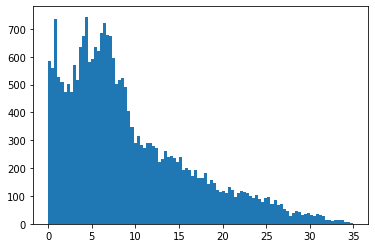

In [57]:
plt.hist(bw_shifts.flatten(),bins=100)
plt.show()

In [70]:
# How likely are we to get a negative dose response sometimes?
# Not very likely with only 25 draws...
print(dose_response_distribution.rvs(25).min())
print(dose_response_distribution.rvs(1000).min())
print(dose_response_distribution.rvs(5000).min())

8.39664689657603
1.6385604561977125
-2.991074477679872
